In [1]:
BLACKHOLE = False


import os
import sys
from pathlib import Path
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # fixes problem with graph


if BLACKHOLE:
    workspace_path = os.path.expandvars('$BLACKHOLE')
    sys.path.append(workspace_path+'/DeepLearning/02456_news_project/src')
    DATAPATH = Path(workspace_path+"/DeepLearning/ebnerd_data").expanduser()
else:
    DATAPATH = Path("~/ebnerd_data").expanduser()

DATASET = "ebnerd_demo"
#DATASET = "ebnerd_small"
#DATASET = "ebnerd_large"

In [2]:
import torch

print("torch version:", torch.__version__)

# Check gpu availability


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Test:
#print(torch.zeros(1).cuda())

torch version: 2.5.1+cu124
cuda


In [3]:
from utils.data_handler import NewsDataset
import from_ebrec._constants as cs

SEED = 42
HISTORY_SIZE = 200
CANDITATE_SIZE = 5

COLS = [
    cs.DEFAULT_USER_COL,
    cs.DEFAULT_IMPRESSION_ID_COL,
    cs.DEFAULT_IMPRESSION_TIMESTAMP_COL,
    cs.DEFAULT_HISTORY_ARTICLE_ID_COL,
    cs.DEFAULT_CLICKED_ARTICLES_COL,
    cs.DEFAULT_INVIEW_ARTICLES_COL,
]

#FRACTION = 0.001
FRACTION = 0.01
#FRACTION = 0.1
#FRACTION = 1

# test
dataset = NewsDataset()

dataset.setup_df(dataset_path = DATAPATH, datasplit = DATASET, history_size = HISTORY_SIZE, columns = COLS, fraction = FRACTION, seed = SEED, candidate_size=CANDITATE_SIZE)


In [4]:
import transformers as huggingface
from from_ebrec._nlp import get_transformers_word_embeddings
from from_ebrec._polars import concat_str_columns
from from_ebrec._articles import convert_text2encoding_with_transformers
from from_ebrec._articles import create_article_id_to_value_mapping

dataset.setup_articles_data(dataset_path = DATAPATH.joinpath(DATASET))

df_articles = dataset.df_articles

TRANSFORMER_MODEL_NAME = "FacebookAI/xlm-roberta-large"
TEXT_COLUMNS_TO_USE = [cs.DEFAULT_SUBTITLE_COL, cs.DEFAULT_TITLE_COL]
MAX_TITLE_LENGTH = 30

# LOAD HUGGINGFACE:
transformer_model = huggingface.AutoModel.from_pretrained(TRANSFORMER_MODEL_NAME)
transformer_tokenizer = huggingface.AutoTokenizer.from_pretrained(TRANSFORMER_MODEL_NAME)

word2vec_embedding = get_transformers_word_embeddings(transformer_model)
df_articles, cat_cal = concat_str_columns(df_articles, columns=TEXT_COLUMNS_TO_USE)
df_articles, token_col_title = convert_text2encoding_with_transformers(df_articles, transformer_tokenizer, cat_cal, max_length=MAX_TITLE_LENGTH)
article_mapping = create_article_id_to_value_mapping(df=df_articles, value_col=token_col_title)



In [ ]:
from src.torch_nerd.dataset import NRMSDataLoader


train_dataloader = NRMSDataLoader(
    behaviors= dataset.df_train,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column= cs.DEFAULT_HISTORY_ARTICLE_ID_COL,
)
for iteration, (data, labels) in enumerate(train_dataloader):
        # Unpacking of batch
        his_input_title, pred_input_title, timestamps = data
        print(iteration, his_input_title.shape, pred_input_title.shape)


0 torch.Size([200, 30]) torch.Size([5, 30])
1 torch.Size([200, 30]) torch.Size([5, 30])
2 torch.Size([200, 30]) torch.Size([5, 30])
3 torch.Size([200, 30]) torch.Size([5, 30])
4 torch.Size([200, 30]) torch.Size([5, 30])
5 torch.Size([200, 30]) torch.Size([5, 30])
6 torch.Size([200, 30]) torch.Size([5, 30])
7 torch.Size([200, 30]) torch.Size([5, 30])
8 torch.Size([200, 30]) torch.Size([5, 30])
9 torch.Size([200, 30]) torch.Size([5, 30])
10 torch.Size([200, 30]) torch.Size([5, 30])
11 torch.Size([200, 30]) torch.Size([5, 30])
12 torch.Size([200, 30]) torch.Size([5, 30])
13 torch.Size([200, 30]) torch.Size([5, 30])
14 torch.Size([200, 30]) torch.Size([5, 30])
15 torch.Size([200, 30]) torch.Size([5, 30])
16 torch.Size([200, 30]) torch.Size([5, 30])
17 torch.Size([200, 30]) torch.Size([5, 30])
18 torch.Size([200, 30]) torch.Size([5, 30])
19 torch.Size([200, 30]) torch.Size([5, 30])
20 torch.Size([200, 30]) torch.Size([5, 30])
21 torch.Size([200, 30]) torch.Size([5, 30])
22 torch.Size([200, 

In [5]:
from nrms import NRMSModel
from hyperparameters import hparams_nrms

hparams = hparams_nrms()

BATCH_SIZE = 64

# PARAMETERS
hparams.title_size = MAX_TITLE_LENGTH
hparams.history_size = HISTORY_SIZE
hparams.batch_size = BATCH_SIZE
hparams.candidate_size = CANDITATE_SIZE

# MODEL ARCHITECTURE
hparams.head_num = 32
hparams.head_dim = 32
hparams.attention_hidden_dim = 200
hparams.linear_hidden_dim = 20
hparams.embedding_dim = word2vec_embedding.shape[1]

hparams.use_positional_encoding = True

hparams.use_time_embedding = False
hparams.time_dim = 1
hparams.time_embedding_dim = 32

# MODEL OPTIMIZER:
hparams.optimizer = "adam"
hparams.loss = "mse_loss"
hparams.dropout = 0.2
hparams.learning_rate = 1e-4

model = NRMSModel(hparams=hparams, word2vec_embedding=word2vec_embedding)

print(model)


NRMSModel(
  (news_encoder): NewsEncoder(
    (embedding): Embedding(250002, 1024)
    (dropout): Dropout(p=0.2, inplace=False)
    (positional_encoder): PositionEncoder(
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (self_attention): SelfAttention(
      (query_proj): Linear(in_features=1024, out_features=1024, bias=True)
      (key_proj): Linear(in_features=1024, out_features=1024, bias=True)
      (value_proj): Linear(in_features=1024, out_features=1024, bias=True)
    )
    (dense_layers): Sequential(
      (0): Linear(in_features=1024, out_features=20, bias=True)
      (1): ReLU()
      (2): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=20, out_features=20, bias=True)
      (5): ReLU()
      (6): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
      (7): Dropout(p=0.2, inplace=False)
      (8): Linear(in_features=20, out_features=1024, bias=True)
      (9): ReLU()
      (10): LayerNorm((1

In [6]:
import torch.nn as nn
import torch.optim as optim

# Define the loss function and optimizer
if hparams.loss == "cross_entropy_loss":
    criterion = nn.CrossEntropyLoss() 
elif hparams.loss == "mse_loss":
    criterion = nn.MSELoss()
else:
    raise ValueError(f"Loss function {hparams.loss} not supported")

if hparams.optimizer == "adam":
    optimizer = optim.Adam(model.parameters(), lr=hparams_nrms.learning_rate)
else:
    raise ValueError(f"Optimizer {hparams.optimizer} not supported")

In [ ]:
from src.torch_nerd.dataset import NRMSDataLoader


train_dataloader = NRMSDataLoader(
    behaviors= dataset.df_train,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column= cs.DEFAULT_HISTORY_ARTICLE_ID_COL,
    batch_size=BATCH_SIZE,
)
val_dataloader = NRMSDataLoader(
    behaviors= dataset.df_validation,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column= cs.DEFAULT_HISTORY_ARTICLE_ID_COL,
    batch_size=BATCH_SIZE,
)

In [9]:
# Train the model 

EPOCHS = 10

# Move model to GPU if available
model.to(device)

# Training loop
train_loss_history, val_loss_history = [], []

for epoch in range(EPOCHS):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    for iteration, (data, labels) in enumerate(train_dataloader):
        # Unpacking of batch
        his_input_title, pred_input_title, timestamps = data
        his_input_title = his_input_title.to(device)
        pred_input_title = pred_input_title.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(pred_input_title, his_input_title)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()


        print(f"Epoch {epoch + 1}/{EPOCHS}, Train iteration {iteration + 1}/{len(train_dataloader)}: Loss = {loss.item():.4f}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for iteration, (data, labels) in enumerate(val_dataloader):
            his_input_title, pred_input_title, timestamps = data

            his_input_title = his_input_title.to(device)
            pred_input_title = pred_input_title.to(device)
            labels = labels.to(device)

            outputs = model(pred_input_title, his_input_title)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()

            print(f"Epoch {epoch + 1}/{EPOCHS}, Val iteration {iteration + 1}/{len(val_dataloader)}: Loss = {loss.item():.4f}")

    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)

    print(f"Epoch {epoch + 1}/{EPOCHS}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")


ValueError: too many values to unpack (expected 2)

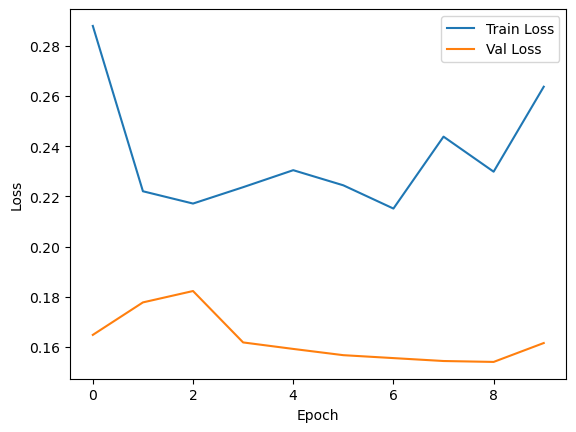

In [20]:
# Plot the loss history
import matplotlib.pyplot as plt

plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [21]:
# Evaluate the model
BATCH_SIZE_TEST = 10

dataset.setup_test_data(dataset_path = DATAPATH, datasplit = DATASET, history_size = HISTORY_SIZE, columns = COLS, fraction = FRACTION, seed = SEED, candidate_size=CANDITATE_SIZE)

test_dataloader = NRMSDataLoader(
    behaviors=dataset.df_test,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column=cs.DEFAULT_HISTORY_ARTICLE_ID_COL,
    batch_size=BATCH_SIZE_TEST,
)

model.eval()

test_loss = 0.0
pred_test = []
labels_test = []
with torch.no_grad():  
    for iteration, (data, labels) in enumerate(test_dataloader):
        his_input_title, pred_input_title, timestamps = data

        his_input_title = his_input_title.to(device)
        pred_input_title = pred_input_title.to(device)
        labels = labels.to(device)

        outputs = model(pred_input_title, his_input_title) 
        loss = criterion(outputs, labels)                 
        test_loss += loss.item()

        for i in range(outputs.size(0)):
            pred_test.append(outputs[i].tolist())
            labels_test.append(labels[i].tolist())

        print(f"Test iteration {iteration + 1}/{len(test_dataloader)}: Loss = {loss.item():.4f}")

    test_loss /= len(test_dataloader)
    print("Test loss:", test_loss)
        
print(pred_test)
print(labels_test)

from from_ebrec.evaluation import MetricEvaluator
from from_ebrec.evaluation import AucScore, MrrScore, NdcgScore
metrics = MetricEvaluator(
    labels = labels_test,
    predictions= pred_test,
    metric_functions=[AucScore(), MrrScore(), NdcgScore(k=5), NdcgScore(k=10)],
)
metrics.evaluate()
print(metrics)



Test iteration 1/3: Loss = 0.1644
Test iteration 2/3: Loss = 0.1637
Test iteration 3/3: Loss = 0.1549
Test loss: 0.16101658840974173
[[0.20164380967617035, 0.28199493885040283, 0.15401583909988403, 0.18117274343967438, 0.18117274343967438], [0.19225075840950012, 0.21605895459651947, 0.212760791182518, 0.19225075840950012, 0.18667876720428467], [0.2663115859031677, 0.19358716905117035, 0.14849354326725006, 0.1963164359331131, 0.19529126584529877], [0.1727498322725296, 0.1727498322725296, 0.17899218201637268, 0.23382772505283356, 0.24168038368225098], [0.17470574378967285, 0.23126834630966187, 0.19002074003219604, 0.1872689574956894, 0.21673625707626343], [0.18230225145816803, 0.305752158164978, 0.305752158164978, 0.1025451198220253, 0.10364826023578644], [0.16690358519554138, 0.1747727394104004, 0.18999284505844116, 0.3014271855354309, 0.16690358519554138], [0.2755585014820099, 0.21645011007785797, 0.15526752173900604, 0.15526752173900604, 0.19745634496212006], [0.20091310143470764, 0.1

AUC: 100%|███████████████████████████████████| 25/25 [00:00<00:00, 12486.02it/s]

<MetricEvaluator class>: 
 {
    "auc": 0.54,
    "mrr": 0.5293333333333333,
    "ndcg@5": 0.6437216712429763,
    "ndcg@10": 0.6437216712429763
}


In [22]:
number_to_print = 20
print("Top %d predictions vs labels:" % number_to_print)
labels = dataset.df_test["labels"].to_list()
for i in range(number_to_print):
    print(f"Article {i}")
    for j in range(len(pred_test[i])):
        print(f"{pred_test[i][j]:.3f} vs {labels[i][j]:.3f}")
    print("")





Top 20 predictions vs labels:
Article 0
0.202 vs 0.000
0.282 vs 0.000
0.154 vs 1.000
0.181 vs 0.000
0.181 vs 0.000

Article 1
0.192 vs 0.000
0.216 vs 1.000
0.213 vs 0.000
0.192 vs 0.000
0.187 vs 0.000

Article 2
0.266 vs 0.000
0.194 vs 0.000
0.148 vs 0.000
0.196 vs 1.000
0.195 vs 0.000

Article 3
0.173 vs 0.000
0.173 vs 0.000
0.179 vs 1.000
0.234 vs 0.000
0.242 vs 0.000

Article 4
0.175 vs 0.000
0.231 vs 0.000
0.190 vs 0.000
0.187 vs 1.000
0.217 vs 0.000

Article 5
0.182 vs 1.000
0.306 vs 0.000
0.306 vs 0.000
0.103 vs 0.000
0.104 vs 0.000

Article 6
0.167 vs 0.000
0.175 vs 0.000
0.190 vs 1.000
0.301 vs 0.000
0.167 vs 0.000

Article 7
0.276 vs 0.000
0.216 vs 1.000
0.155 vs 0.000
0.155 vs 0.000
0.197 vs 0.000

Article 8
0.201 vs 0.000
0.197 vs 0.000
0.197 vs 0.000
0.190 vs 0.000
0.216 vs 1.000

Article 9
0.200 vs 1.000
0.179 vs 0.000
0.179 vs 0.000
0.236 vs 0.000
0.206 vs 0.000

Article 10
0.286 vs 0.000
0.105 vs 1.000
0.286 vs 0.000
0.142 vs 0.000
0.182 vs 0.000

Article 11
0.158 vs 0.0

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt


# Flatten the data for analysis
predicted_probabilities = [prob for article in pred_test for prob in article]
true_values = [val for article in labels[:len(pred_test)] for val in article]


# Set a threshold (commonly 0.5) to classify probabilities as 0 or 1
threshold = 0.5
predicted_classes = [1 if p >= threshold else 0 for p in predicted_probabilities]

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_values, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate AUC and ROC curve
fpr, tpr, thresholds = roc_curve(true_values, predicted_classes)
roc_auc = auc(fpr, tpr)

# Plot ROC curve with AUC value explicitly highlighted
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()